### Online Learning of Temporal Dependencies for Sustainable Foraging Problem - Code
#### Imports

In [17]:
# Math
import numpy as np
import random

# Data handling
from collections import deque
import copy

# Neural networks
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Plotting, progress reporting, and file handling
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm

#### Environment Class

In [18]:
# Define environment
class Environment:
    def __init__(self, initial_resources, regeneration_rate, carrying_capacity, resource_cap):
        self.resources = initial_resources
        self.regeneration_rate = regeneration_rate
        self.carrying_capacity = carrying_capacity
        self.resource_cap = resource_cap

#### Network Classes

In [19]:
# Define networks
# LSTMNetwork used by LSTM agents otherwise DeepQNetwork used
# Softmax activation function over output layer perfomed agent-side to obtain action probability distribution

class DeepQNetwork(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=3, output_dim=1):
        super(DeepQNetwork, self).__init__()
        # Define the first fully connected layer (input layer to hidden layer)
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # Define the second fully connected layer (hidden layer to output layer)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Pass data through fc1
        x = F.relu(self.fc1(x))  # Apply ReLU activation function
        # Pass data through fc2
        x = self.fc2(x)
        return x

class LSTMNetwork(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=3, output_dim=1, num_layers=1):
        super(LSTMNetwork, self).__init__()
        # LSTM Layer: Handles sequence input with 'hidden_dim' hidden neurons
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        # Fully connected layer: Maps from the last hidden state of the LSTM to output neurons
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # pass data through LSTM
        lstm_out, _ = self.lstm(x)
        x = lstm_out[:, -1, :]  # Get the last time step output
        # pass data through fully connected layer
        x = self.fc(x)
        return x

#### Agents
##### Base Agent
The base agent class is used by all agent classes and contains key agent properties and functions that are the same for all sub-classes of agent

In [20]:
# Define base agent class: used by all agents manages properties and actions that are the same for all agents

class BaseAgent:
    def __init__(self, agent_params):
        """ Initializes base agent with provided parameters """
        eta, self.carry_capacity, self.survival_cost, self.tau, self.k = tuple(agent_params.values())
        self.energy = random.randint(eta-10, eta+10) # fuzzy eta avoids all agents gathering on same time step

        self.alive = True
        self.time_alive = 0

        self.actions = []
        self.gathering = False
        self.gather_amounts = []
        self.current_reward = 0
        self.total_reward = 0
        self.all_rewards = []
    
    def perform_action(self, available_resources):
        """ Determines how many resources are gathered by agents and adds this to their energy """

        if self.gathering == True:
            self.gather_amounts.append(min(available_resources, self.carry_capacity))
        else:
            self.gather_amounts.append(0)

        self.energy += self.gather_amounts[-1] # add gathered resources to energy
        
    def apply_survival_cost(self):
        """ Subtracts survival cost from agent energy and sets agent to dead if no energy remaining """
        
        self.energy -= self.survival_cost # reduce agent energy by survival cost
        if self.energy <= 0:
            self.alive = False # if agent is out of energy then agent dies
        else:
            self.time_alive += 1 # if agent is still alive increment time alive counter

    def calculate_reward(self):
        """ Calculates logarithmic reward based on agent energy """
        if self.energy <= 0:
            reward = 0 # if agent has no energy reward is zero
        else:
            reward = self.k * np.log(self.energy) # agent reward based on log of energy level
        
        # update rewards
        self.current_reward = reward
        self.total_reward += reward
        self.all_rewards.append(reward)

##### Moderate and Greedy Agents

In [21]:
# Define base agent classes
# base moderate agent only takes moderate actions, or the most moderate action given a range of actions
# base greedy agent only takes greedy actions

class Greedy_Agent(BaseAgent):
    def __init__(self, agent_params):
        super().__init__(agent_params)
    
    def decide_action(self, observation):
        action = len(self.tau)-1 # always chooses highest threshold value
        if self.energy <= self.tau[action]:
            self.gathering = True
        else:
            self.gathering = False
                
        self.actions.append(action)

class Moderate_Agent(BaseAgent):
    def __init__(self, agent_params):
        super().__init__(agent_params)
    
    def decide_action(self, observation):
        action = 0 # always chooses lowest threshold value
        if self.energy <= self.tau[action]:
            self.gathering = True
        else:
            self.gathering = False
                
        self.actions.append(action)

##### DRQN Agents

In [22]:
class DRQN_Agent(BaseAgent):
    def __init__(self, agent_params, DQN_params):
        super().__init__(agent_params)

        # load parameters from parameeter dictionary
        self.lr, self.discount_factor, self.exploration_rate, self.exploration_decay = tuple(DQN_params.values())

        # initialise network
        self.n_choices = len(self.tau)
        self.network = DeepQNetwork(input_dim=self.n_choices+3, output_dim=self.n_choices)
        self.optimizer = optim.Adam(self.network.parameters(), lr=self.lr)

    def decide_action(self, observation):
        if np.random.rand() < self.exploration_rate:
            action = np.random.randint(0, self.n_choices)
        else:
            # use network to determine energy threshold for gathering
            with torch.no_grad():
                observation_tensor = torch.FloatTensor(observation).unsqueeze(0)  # Convert observation to tensor
                output = torch.softmax(self.network(observation_tensor), dim=1)
                action = np.argmax(output).item()
        
        # set gathering to True if energy below threshold or False if energy above threshold
        if self.energy <= self.tau[action]:
            self.gathering = True
        else:
            self.gathering = False

        self.actions.append(action)

    def conduct_learning(self, state, next_state):
        # Convert to tensors
        state_t = torch.FloatTensor(state).unsqueeze(0)
        action = self.actions[-1]

        # Get the predicted Q-value for the chosen action
        predicted_q_values = self.network(state_t)
        predicted_q_value_for_action = predicted_q_values[0][action]

        reward = torch.FloatTensor([self.all_rewards[-1]])
        reward = reward.squeeze()
        loss = F.mse_loss(predicted_q_value_for_action, reward)

        # Backpropagate the loss, update the network weights
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update exploration rate
        self.exploration_rate *= self.exploration_decay

In [23]:
class LSTM_DRQN_Agent(BaseAgent):
    def __init__(self, agent_params, DQN_params, LSTM_params):
        super().__init__(agent_params)

        # load parameters from parameter dictionaries
        self.lr, self.discount_factor, self.exploration_rate, self.exploration_decay = tuple(DQN_params.values())
        self.observation_length, self.reward_length, self.discount_factor = tuple(LSTM_params.values())

        # initialise network
        self.n_choices = len(self.tau)
        self.network = LSTMNetwork(input_dim=self.n_choices+3, output_dim=self.n_choices)
        self.optimizer = optim.Adam(self.network.parameters(), lr=self.lr)

        # create observation buffer to provide series of observations to LSTM network
        self.observation_buffer = deque(maxlen=self.observation_length)
        self.recent_rewards = deque([], maxlen=self.reward_length)

    def decide_action(self, observation):
        self.observation_buffer.append(observation)

        if np.random.rand() < self.exploration_rate:
            action = np.random.randint(0, self.n_choices)
        else:
            # use network to determine energy threshold for gathering
            with torch.no_grad():
                observation_tensor = torch.FloatTensor(self.observation_buffer).unsqueeze(0)  # Convert observation to tensor
                output = torch.softmax(self.network(observation_tensor), dim=1)
                action = np.argmax(output).item()

        # set gathering to True if energy below threshold or False if energy above threshold        
        if self.energy <= self.tau[action]:
            self.gathering = True
        else:
            self.gathering = False
                
        self.actions.append(action)

    def conduct_learning(self, state, next_state):
        state_t = torch.FloatTensor(self.observation_buffer).unsqueeze(0)
        next_state_buffer = deque([o for o in self.observation_buffer], maxlen=self.observation_length)
        next_state_buffer.append(next_state)
        next_state_t = torch.FloatTensor(next_state_buffer).unsqueeze(0)
        action = self.actions[-1]

        # Get the predicted Q-value for the chosen action
        predicted_q_values = self.network(state_t)
        predicted_q_value_for_action = predicted_q_values[0][action]

        reward = torch.FloatTensor([self.all_rewards[-1]])
        reward = reward.squeeze()
        loss = F.mse_loss(predicted_q_value_for_action, reward)

        # Backpropagate the loss, update the network weights
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update exploration rate
        self.exploration_rate *= self.exploration_decay


##### Online Neuro-Evolution Agents

In [24]:
# Evolutionary algorithm functions used by online neuro-evolution agents

def softmax_selection(scores):
    """ Selects an index based on softmax probabilities """
    probabilities = np.exp(scores - np.max(scores))
    probabilities /= probabilities.sum()
    selected_index = np.random.choice(len(scores), p=probabilities)
    return selected_index

def tournament_selection(fitness_scores, tournament_size=3):
    """ Selects an individual by tournament selection """
    selected_indices = np.random.choice(len(fitness_scores), tournament_size, replace=False)
    selected_fitness = fitness_scores[selected_indices]
    selected_index = selected_indices[np.argmax(selected_fitness)]
    return selected_index

def arithmetic_crossover(network, net1, net2):
    """ Averages the weights of two networks to create a new one via arithmetic crossover """
    child = copy.deepcopy(network)
    with torch.no_grad():
        for child_param, param1, param2 in zip(child.parameters(), net1.parameters(), net2.parameters()):
            child_param.data.copy_((param1.data + param2.data) / 2)
    return child

def mutate_network(network, mutation_rate=0.1, scale=0.02):
    """ Mutates the network by adding noise to the weights """
    with torch.no_grad():
        for param in network.parameters():
            if np.random.rand() < mutation_rate:
                noise = torch.randn_like(param) * scale
                param.add_(noise)

In [25]:
class NE_Agent(BaseAgent):
    def __init__(self, agent_params, NE_params):
        super().__init__(agent_params)

        # load parameters from parameter dictionary
        self.pop_size, self.tournament_size, self.mutation_rate, self.mutation_scale = tuple(NE_params.values())

        # initialise networks
        self.n_choices = len(self.tau)
        self.network = DeepQNetwork(input_dim=self.n_choices+3, output_dim=self.n_choices)
        self.networks = [DeepQNetwork(input_dim=self.n_choices+3, output_dim=self.n_choices) for _ in range(self.pop_size)] # create poputlation of networks
        self.fitness_scores = np.array([(self.k * np.log(self.energy)) for _ in range(self.pop_size)])
        self.selected_network_index = None

    def decide_action(self, observation):
        # optionally use tournamet selection rather than softmax prior to specified timestep
        if self.time_alive < 0:
            self.selected_network_index = tournament_selection(self.fitness_scores)
        else:
            # determine which network to use based on softmax selection of fitness scores
            self.selected_network_index = softmax_selection(self.fitness_scores)
        selected_network = self.networks[self.selected_network_index]
        
        # use selected network to determine energy threshold for gathering
        with torch.no_grad():
            observation_tensor = torch.FloatTensor(observation).unsqueeze(0)  # Convert observation to tensor
            output = torch.softmax(selected_network(observation_tensor), dim=1)
            action = np.argmax(output).item()
        self.actions.append(action)

        # set gathering to True if energy below threshold or False if energy above threshold
        if self.energy <= self.tau[action]:
            self.gathering = True
        else:
            self.gathering = False

    def evolve_networks(self):
        """ Evolves network population based on network fitness scores """
        self.fitness_scores[self.selected_network_index] = self.current_reward # update reward for last used network
        worst_index = np.argmin(self.fitness_scores) # obtain index of worst performing network

        # specify parent networks
        idx1 = tournament_selection(self.fitness_scores)
        idx2 = tournament_selection(self.fitness_scores)
        parent1 = self.networks[idx1]
        parent2 = self.networks[idx2]

        # determine child fitness from average of parent fitnesses
        parent_avg_fitness = (self.fitness_scores[idx1] + self.fitness_scores[idx2]) / 2

        child = arithmetic_crossover(self.network, parent1, parent2) # perform crossover of parent networks
        mutate_network(child) # perform mutation of child network

        # replace weakest network in population with child network
        self.networks[worst_index] = child
        self.fitness_scores[worst_index] = parent_avg_fitness


In [26]:
class LSTM_NE_Agent(BaseAgent):
    def __init__(self, agent_params, NE_params, LSTM_params):
        super().__init__(agent_params)

        # load parameters from parameter dictionaries
        self.pop_size, self.tournament_size, self.mutation_rate, self.mutation_scale = tuple(NE_params.values())
        self.observation_length, self.reward_length, self.discount_factor = tuple(LSTM_params.values())

        # initialise networks
        self.n_choices = len(self.tau)
        self.network = LSTMNetwork(output_dim=self.n_choices)
        self.networks = [copy.deepcopy(self.network) for _ in range(self.pop_size)] # create poputlation of networks
        self.fitness_scores = np.array([(self.k * np.log(self.energy)) for _ in range(self.pop_size)])
        self.selected_network_index = None

        # create observation buffer to provide series of observations to LSTM network
        self.observation_buffer = deque(maxlen=self.observation_length)
        self.recent_rewards = deque([], maxlen=self.reward_length)


    def decide_action(self, observation):
        self.observation_buffer.append(observation)
        observation_sequence = torch.FloatTensor([self.observation_buffer])

        # optionally use tournamet selection rather than softmax prior to specified timestep
        if self.time_alive < 0:
            self.selected_network_index = tournament_selection(self.fitness_scores)
        else:
            # determine which network to use based on softmax selection of fitness scores
            self.selected_network_index = softmax_selection(self.fitness_scores)
        selected_network = self.networks[self.selected_network_index]
        
        # use selected network to determine energy threshold for gathering
        with torch.no_grad():
            output = torch.softmax(selected_network(observation_sequence), dim=1)
            action = np.argmax(output).item()

        # set gathering to True if energy below threshold or False if energy above threshold        
        self.actions.append(action)
        if self.energy <= self.tau[action]:
            self.gathering = True
        else:
            self.gathering = False

    
    def evolve_networks(self):
        """ Evolves network population based on network fitness scores """
        self.fitness_scores[self.selected_network_index] = self.current_reward # update reward for last used network
        worst_index = np.argmin(self.fitness_scores) # obtain index of worst performing network

        # specify parent networks
        idx1 = tournament_selection(self.fitness_scores)
        idx2 = tournament_selection(self.fitness_scores)
        parent1 = self.networks[idx1]
        parent2 = self.networks[idx2]

        # determine child fitness from average of parent fitnesses
        parent_avg_fitness = (self.fitness_scores[idx1] + self.fitness_scores[idx2]) / 2

        child = arithmetic_crossover(self.network, parent1, parent2) # perform crossover of parent networks
        mutate_network(child) # perform mutation of child network

        # replace weakest network in population with child network
        self.networks[worst_index] = child
        self.fitness_scores[worst_index] = parent_avg_fitness


#### Base Parameter dictionary

In [27]:
params_dict = {
    'env_params': {
        'initial resources': 500,
        'resource growth rate': 1.005,
        'environment carry capacity': 2500
    },
    'agent_params': {
        'agent initial energy': 100,
        'agent carry capacity': 5,
        'agent survival cost': 2,
        'agent threshold energy': [30, 50, 80, 50000], # threshold choices available to agents
        'reward scaling': 100
    },
    'pop_params': { # dictates number of agents of each type to be simulated
        'moderate': 0,
        'greedy': 0,
        'DRQN': 0,
        'LSTM-DRQN': 0,
        'NE': 0,
        'LSTM-NE': 0
    },
    'DQN_params': { # Q-learning parameters used for DRQN agents
        'learning rate': 0.025,
        'discount factor': 0.95,
        'exploration rate': 1,
        'exploration decay': 0.99
    },
    'NE_params': { # EA parameters used for online neuroevolution agents
        'pop_size': 30,
        'tournament size': 5,
        'mutation rate': 0.2,
        'mutation scale': 0.06
    },
    'LSTM_params': { # parameters for LSTM networks
        'observation length': 25, # length of series of observations to be passed to LSTM
        'reward length': 1, # not used in current implementation
        'discount factor': 0.95
    },
    'expmt_params': {
        'experiment name': 'None',
        'num timesteps': 1000,
        'num runs': 30
    }
}

#### Simulating Agent Foraging

In [28]:
def simulate_foraging(params_dict):
    """ Core function to simulate foraging agents for a specified set of parameters """

    # unpack required parameters
    env_params, agent_params, pop_params, DQN_params, NE_params, LSTM_params, expmt_params = tuple(params_dict.values())
    expmt_name, num_timesteps, num_runs = tuple(expmt_params.values())

    # initialise environment
    r1, alpha, K = tuple(env_params.values())
    num_agents = sum(tuple(pop_params.values()))
    C = r1*num_agents # environment resource cap
    env = Environment(initial_resources=(r1*num_agents), regeneration_rate=alpha, carrying_capacity=K, resource_cap=C)

    # initialise agents
    n_moderate, n_greedy, n_DRQN, n_LSTMDRQN, n_NE, n_LSTMNE = tuple(pop_params.values()) # unpack populations
    agents = [] # create list for agent instances
    
    # initialise required number of agents for each class and add to list
    agents.extend([Moderate_Agent(agent_params) for _ in range(n_moderate)])
    agents.extend([Greedy_Agent(agent_params) for _ in range(n_greedy)])
    agents.extend([DRQN_Agent(agent_params, DQN_params) for _ in range(n_DRQN)])
    agents.extend([LSTM_DRQN_Agent(agent_params, DQN_params, LSTM_params) for _ in range(n_LSTMDRQN)])
    agents.extend([NE_Agent(agent_params, NE_params) for _ in range(n_NE)])
    agents.extend([LSTM_NE_Agent(agent_params, NE_params, LSTM_params) for _ in range(n_LSTMNE)])

    # Create initial observation
    taus = agent_params.get('agent threshold energy')
    n_choices = len(taus)
    observation = [0] * (n_choices + 3)
    count_alive = sum(1 for agent in agents if agent.alive)
    observation[0] = env.resources
    observation[1] = count_alive
    observations = [observation]

    # Main Simulation Loop
    for timestep in range(num_timesteps):
        observation = observations[timestep] # specify current observation
        next_observation = [0] * (n_choices + 3)
        alive_agents = [agent for agent in agents if agent.alive] # create list of currently alive agents

        # for each agent decide action
        for agent in alive_agents:
            agent.decide_action(observation)

        # determine avalible resources based on number of gathering agents
        count_gathering = sum(1 for agent in agents if (agent.gathering == True))
        if count_gathering == 0:
            available_resources = env.resources # handle case where no agents are gathering
        else: available_resources = env.resources/count_gathering # maximum avalible resource for agents
        
        # perform actions for all alive agents
        for agent in alive_agents:
            agent.perform_action(available_resources)
            env.resources -= agent.gather_amounts[-1]
            agent.apply_survival_cost()
            agent.calculate_reward()


        # update resources
        env.resources = env.resources * env.regeneration_rate   # exponential growth of resources
        env.resources = min(env.resources, env.resource_cap)  # cap of max resources

        # construct next observation
        count_alive = sum(1 for agent in agents if agent.alive)
        
        next_observation[0] = env.resources
        next_observation[1] = count_alive
        next_observation[2] = count_gathering
        
        for i in range(n_choices):
            next_observation[3+i] = sum(1 for agent in agents if agent.actions[-1] == i)

        observations.append(next_observation)

        # update networks for agents that are still alive
        alive_agents = [agent for agent in agents if agent.alive] # redetermine alive agents
        for agent in alive_agents:
            if hasattr(agent, 'conduct_learning'):
                agent.conduct_learning(observation, next_observation) # Q-Learning
            if hasattr(agent, 'evolve_networks'):
                agent.evolve_networks() # online neruo-evolution

        # Simulation break conditions
        # early stopping for condition where all agents have died
        if sum(1 for agent in agents if agent.alive) == 0:
            # print(f'All agents are dead at timestep {timestep}')
            break
        
        # early stopping for condition wher all resources are depleted
        # if env.resources == 0:
            # print(f'All resources are depleted at timestep {timestep}')
            break

    # Calaculate statistics
    lifetimes = []
    gather_amounts = []
    total_rewards = []
    for agent in agents:
        lifetimes.append(agent.time_alive)
        gather_amounts.append(sum(agent.gather_amounts))
        total_rewards.append(agent.total_reward)
    mean_lifetime = np.mean(lifetimes)
    mean_gather_amount = np.mean(gather_amounts)
    mean_reward = np.mean(total_rewards)
    
    count_alive = sum(1 for agent in agents if agent.alive)
    survival_rate = count_alive/num_agents

    stats = [mean_lifetime, mean_gather_amount, mean_reward, survival_rate]

    obervations = np.array(observations)
    return obervations, stats

def repeated_simulations(params_dict):
    """ conducts repeated simulations for a given set of parameters for a specified number of runs """
    expmt_name, num_timesteps, num_runs = tuple(params_dict['expmt_params'].values()) # unpack experiment parameters
    run_progbar = tqdm(total=num_runs, desc='Conducting simulations') # create progress bar

    taus = params_dict['agent_params']['agent threshold energy']
    n_cols = len(taus) + 3
    output_shape = (num_timesteps+1, n_cols) # specify expected output shape of observation history

    observations_list = [] # initialise list for storing observation history of each run
    stats_list = [] # initialise list to store run statistics
    
    for _ in range(num_runs):
        observations, stats = simulate_foraging(params_dict) # conduct simulation
        stats_list.append(stats) # record statistics
        
        # check observation history is correct shape and pad if required
        if observations.shape != output_shape:
            n_rows_to_add = output_shape[0] - observations.shape[0]
            observations = np.pad(observations, ((0, n_rows_to_add), (0, 0)), mode='constant')

        observations_list.append(observations) # record observation history
        run_progbar.update(1)

    # calculate overall mean of observation history
    overall_mean_observations = np.mean(observations_list, axis=0)

    # calculate alive agent filtered mean of observation history
    masked_array = np.ma.array(observations_list)
    mask = masked_array[:, :, 1] <= 0
    masked_array = np.ma.masked_array(masked_array, mask=np.repeat(mask[:, :, np.newaxis], n_cols, axis=2))
    filtered_mean_observations = masked_array.mean(axis=0)
    mean_observations = filtered_mean_observations.copy()
    mean_observations[:, 1] = overall_mean_observations[:, 1]

    # calculate mean of run statistics
    mean_stats = np.mean(stats_list, axis=0)
    std_dev_stats = np.std(stats_list, axis=0, ddof=1)

    run_progbar.close()
    return mean_observations, mean_stats, std_dev_stats

def conduct_experiment(params_dict, param_group, param, param_values):
    """ conducts simulations for a range of provided parameters and records run-averaged statistics """
    experiment_params_dict = copy.deepcopy(params_dict) # create copy of params for experiment
    experiment_stats = [] # initialise list to store experiment statistics
    error = []
    
    for i, value in enumerate(param_values):
        experiment_params_dict[param_group][param] = value # modify parameter value in dictionary
        mean_observations, mean_stats, std_dev_stats = repeated_simulations(experiment_params_dict) # run simulation with parameters
        experiment_stats.append(mean_stats) # record run-averaged statistics
        error.append(std_dev_stats[2])

    experiment_stats = np.stack(experiment_stats)

    return experiment_stats, error

def compare_models(params_dict, num_agents=1, keys=None):
    """ Obtains run-averaged observations and stats for all models """
    base_dict = copy.deepcopy(params_dict) # make deep copy of parameter dictionary
    observations, stats = [], []

    if keys == None:
        keys = base_dict['pop_params'].keys()

    for key in base_dict['pop_params'].keys():
        base_dict['pop_params'][key] = 0 # initially set population of all agent types to zero

    for key in keys:
        run_dict = copy.deepcopy(base_dict)
        run_dict['pop_params'][key] = num_agents
        model_observations, model_stats, std_dev_stats = repeated_simulations(run_dict)
        observations.append(model_observations)
        stats.append(model_stats)
    
    stats = np.stack(stats)
    return observations, stats



#### Plotting Functions

In [29]:
def plot_observations(observations, title=None, thresholds=None):
    """ Plots forraging simulation results from observation records"""
    plt.rcdefaults()
    plt.style.use('tableau-colorblind10')
    colors = ['#006BA4', '#FF800E', '#A2C8EC', '#FFBC79']
    x_axis = np.arange(len(observations)) # x-axis is number of timesteps
    # agent plotting
    fig, ax1 = plt.subplots(figsize=(9,6))

    for i in range(len(observations[0])-3):
        if thresholds is not None:
            ax1.plot(x_axis, observations[:, (3+i)], '-', color=colors[i], label=r'$\tau$'+f'={thresholds[i]}')
            # ax1.plot(x_axis, observations[:, (3+i)], '-', label=r'$\tau$'+f'={thresholds[i]}')
            # ax1.plot(x_axis, observations[:, (3+i)], '-', label=f'{thresholds[i]}')
        else:
            ax1.plot(x_axis, observations[:, (3+i)], '-', label=f'T{i} agents')
    ax1.plot(x_axis, observations[:, 1], 'k-', label='alive agents')
    ax1.set_xlabel('Time steps', fontsize=18)
    ax1.set_ylabel('Agent count', color='black', fontsize=16)
    ax1.tick_params(axis='y', labelsize=16, labelcolor='black')
    ax1.tick_params(axis='x', labelsize=18, labelcolor='black')
    # resource plotting
    ax2 = ax1.twinx()
    ax2.plot(x_axis, observations[:, 0], 'k--', label='resources')
    ax2.set_ylabel('Resource in the environment', color='black', fontsize=16)
    ax2.tick_params(axis='y', labelsize=16, labelcolor='black')
    ax2.tick_params(axis='x', labelsize=18, labelcolor='black')

    # add title, labels, and legend
    if title is not None:
        plt.title(title, fontsize=20)
    else:
        plt.title('foraging results', fontsize=16)
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()

    ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right', fontsize=12)

    # timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    # filepath = f'plots/{timestamp}.png'
    # plt.savefig(filepath)
    plt.show() # show plot

def plot_results(param, param_values, experiment_stats):
    """ Plots forraging simulation results from observation records"""
    x_axis = param_values
    # agent plotting
    fig, ax1 = plt.subplots(figsize=(10,6))
    ax1.plot(x_axis, experiment_stats[:, 2], 'g-', label='total reward')
    ax1.set_xlabel('parameter value')
    ax1.set_ylabel('value', color='black')
    ax1.tick_params(axis='y', labelcolor='black')
    # resource plotting
    ax2 = ax1.twinx()
    ax2.plot(x_axis, experiment_stats[:, 3], 'k-', label='survival rate')
    ax2.set_ylabel('survival rate', color='black')
    ax2.tick_params(axis='y', labelcolor='black')

    # add title, labels, and legend
    plt.title('foraging results')
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', bbox_to_anchor=(1.1, 1))

    # timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    # filepath = f'plots/{timestamp}.png'
    # plt.savefig(filepath)
    plt.show()  # show plot

def plot_models(params_dict, observations, agent_types=None, title=None):
    """ Plots forraging simulation results from observation records"""
    plt.style.use('tableau-colorblind10')
    x_axis = np.arange(len(observations[0])) # x-axis is number of timesteps
    
    if agent_types == None:
        agent_types = list(params_dict['pop_params'].keys())

    # plot reward
    fig, ax1 = plt.subplots(figsize=(9,6))
    for i, agent_type in enumerate(agent_types):
        ax1.plot(x_axis, observations[i][:, 1], linestyle='-', label=f'{agent_type} agents')
    ax1.set_xlabel('Time steps', fontsize=18)
    ax1.set_ylabel('Agent count', color='black', fontsize=16)
    ax1.tick_params(axis='y', labelsize=16, labelcolor='black')
    ax1.tick_params(axis='x', labelsize=18, labelcolor='black')

    # plot survival rate
    ax2 = ax1.twinx()
    for i, agent_type in enumerate(agent_types):
        ax2.plot(x_axis, observations[i][:, 0], linestyle='--', label=f'{agent_type} resources')
    ax2.set_ylabel('Resource in the environment', color='black', fontsize=16)
    ax2.tick_params(axis='y', labelsize=16, labelcolor='black')

    # add title, labels, and legend
    if title is not None:
        plt.title(title, fontsize=20)
    else:
        plt.title('foraging results', fontsize=16)
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax2.legend(lines_1 + lines_2, labels_1 + labels_2, fontsize=12)

    # timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    # filepath = f'plots/{timestamp}.png'
    # plt.savefig(filepath)
    plt.show() # show plot

def plot_models_without_resource(params_dict, observations, agent_types=None, title=None):
    """ Plots forraging simulation results from observation records"""
    plt.style.use('tableau-colorblind10')
    colors = ['#A2C8EC', '#006BA4', '#FFBC79', '#FF800E', '#bdbdbd', '#000000'] # custom colour mapping
    x_axis = np.arange(len(observations[0])) # x-axis is number of timesteps
    
    if agent_types == None:
        agent_types = list(params_dict['pop_params'].keys())

    # plot reward
    fig, ax1 = plt.subplots(figsize=(9,6))
    for i, agent_type in enumerate(agent_types):
        ax1.plot(x_axis, observations[i][:, 1], linestyle='-', color=colors[i], label=f'{agent_type} agents')
    ax1.set_xlabel('Time steps', fontsize=18)
    ax1.set_ylabel('Agent count', color='black', fontsize=18)
    ax1.tick_params(axis='y', labelsize=18, labelcolor='black')
    ax1.tick_params(axis='x', labelsize=18, labelcolor='black')

    # plot survival rate
    # ax2 = ax1.twinx()
    # for i, agent_type in enumerate(agent_types):
    #     ax2.plot(x_axis, observations[i][:, 0], linestyle='--', label=f'{agent_type} resources')
    # ax2.set_ylabel('Resource in the environment', color='black', fontsize=14)
    # ax2.tick_params(axis='y', labelsize=14, labelcolor='black')

    # add title, labels, and legend
    if title is not None:
        plt.title(title, fontsize=20)
    else:
        plt.title('foraging results', fontsize=16)
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    # lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1, labels_1, fontsize=12)

    # timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    # filepath = f'plots/{timestamp}.png'
    # plt.savefig(filepath)

    plt.show() # show plot

#### Figures

The following figures correspond to those presented in the Online Learning of Temporal Dependencies for Sustainable Foraging Problem paper.

##### Figure 1 - Comparison of moderate and greedy agents

Conducting simulations: 100%|██████████| 30/30 [00:00<00:00, 138.25it/s]


[[1.00000000e+03 1.92933333e+03 3.45715646e+05 1.00000000e+00]
 [3.94366667e+02 6.89903658e+02 2.12389216e+05 0.00000000e+00]]


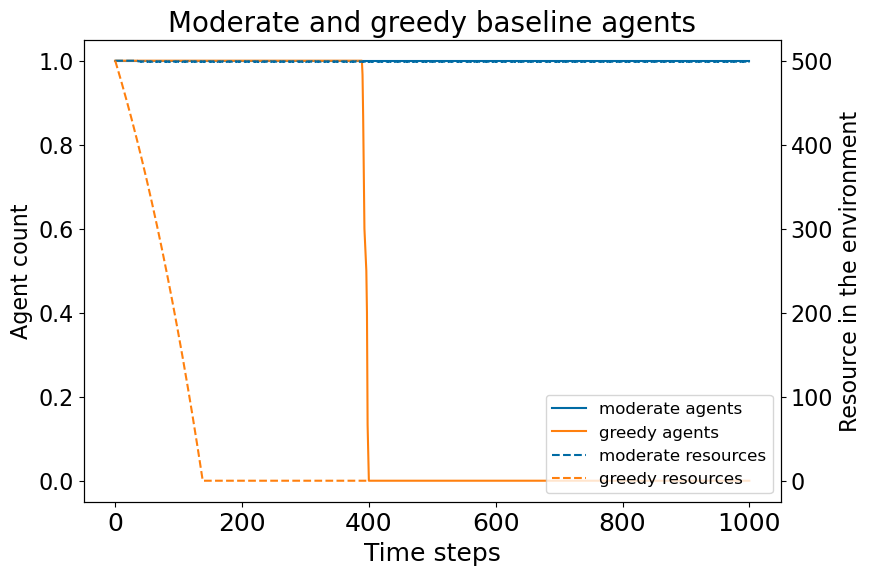

In [31]:
agent_types = ['moderate', 'greedy'] # specify models for comparison, if none all models are compared
observations, stats = compare_models(params_dict, num_agents=1, keys=agent_types) # run model comparison
print(stats) # [mean lifetime, mean amount gathered, mean total reward, survival rate]
title = 'Moderate and greedy baseline agents'
plot_models(params_dict, observations, agent_types, title) # Plot model comparison

##### Figure 2 - Online Neuroevolution with moderate or greedy thresholds for a single agent

Conducting simulations: 100%|██████████| 30/30 [00:20<00:00,  1.46it/s]


[   401.93333333    704.44033691 215268.96692809      0.        ]
[  12.46493934   23.00229403 5148.72705501    0.        ]
0.0


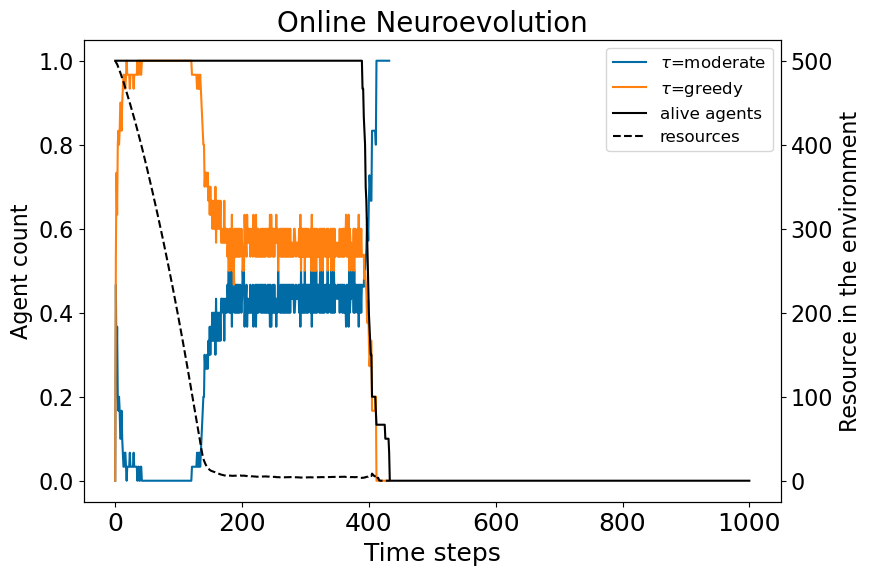

In [32]:
experiment_dict2 = copy.deepcopy(params_dict) # make deep copy of parameter dictionary
experiment_dict2['pop_params']['NE'] = 1
experiment_dict2['agent_params']['agent threshold energy'] = [30, 5000]
observations2, stats2, std_dev2 = repeated_simulations(experiment_dict2)
print(stats2)
print(std_dev2)
print(np.sqrt(30 * stats2[-1] * (1 - stats2[-1])))
title2 = 'Online Neuroevolution'
ths2 = ['moderate', 'greedy']
plot_observations(observations2, title2, ths2)

##### Figure 3 - Online Neuroevolution with moderate or greedy thresholds for 10 agents

[   403.27666667    707.71612796 216908.71868058      0.        ]
[   5.71016537   11.19799283 3185.11733654    0.        ]
0.0


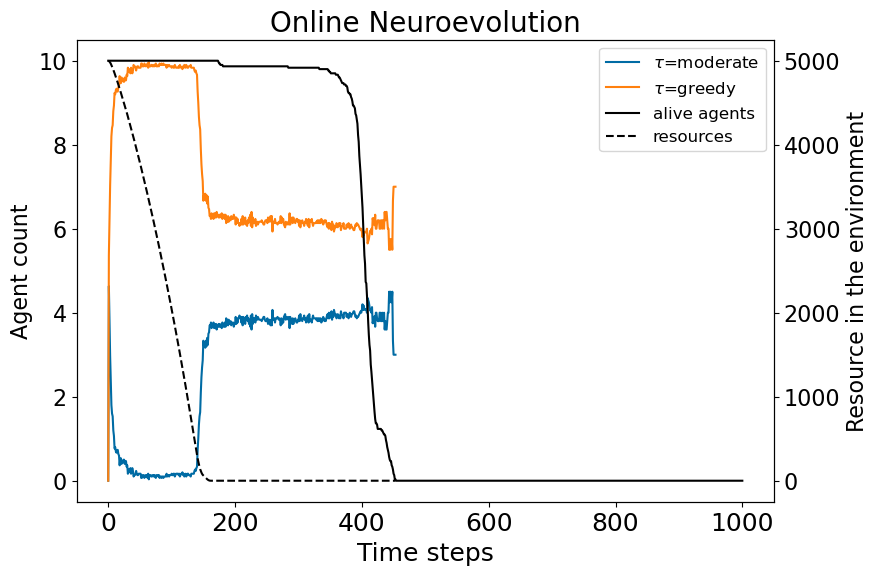

In [231]:
experiment_dict3 = copy.deepcopy(params_dict) # make deep copy of parameter dictionary
experiment_dict3['pop_params']['NE'] = 10
experiment_dict3['agent_params']['agent threshold energy'] = [30, 5000]
# experiment_dict['expmt_params']['num timesteps'] = 500
observations3, stats3, std_dev3 = repeated_simulations(experiment_dict3)
print(stats3)
print(std_dev3)
print(np.sqrt(30 * stats3[-1] * (1 - stats3[-1])))
title3 = 'Online Neuroevolution'
ths3 = ['moderate', 'greedy']
plot_observations(observations3, title3, ths3)

##### Figure 4 - Deep Recurrent Q-Network with moderate or greedy thresholds for a single agent

[5.75400000e+02 1.05806562e+03 2.75688093e+05 1.66666667e-01]
[1.94391819e+02 3.99769081e+02 3.88055799e+04 3.79049022e-01]
2.041241452319315


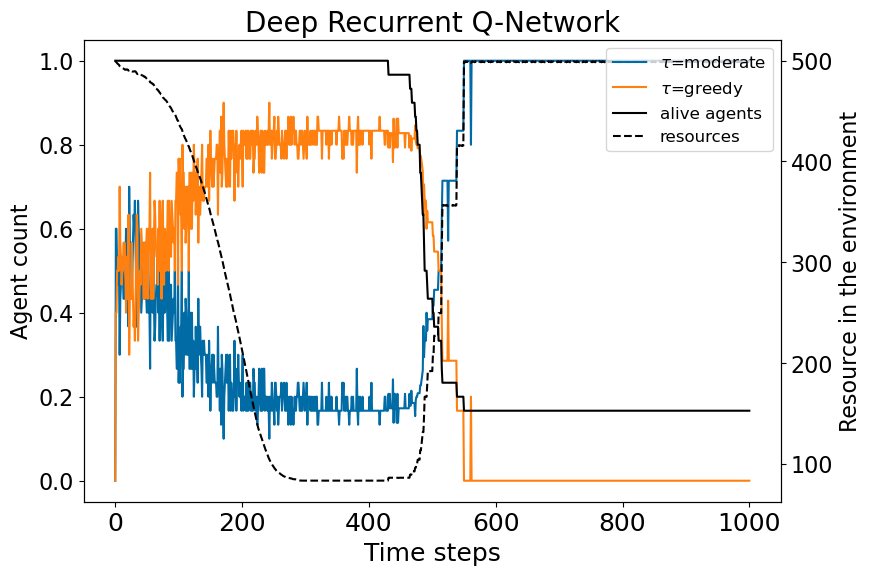

In [232]:
experiment_dict4 = copy.deepcopy(params_dict) # make deep copy of parameter dictionary
experiment_dict4['pop_params']['DRQN'] = 1
experiment_dict4['agent_params']['agent threshold energy'] = [30, 5000]
observations4, stats4, std_dev4 = repeated_simulations(experiment_dict4)
print(stats4)
print(std_dev4)
print(np.sqrt(30 * stats4[-1] * (1 - stats4[-1])))
title4 = 'Deep Recurrent Q-Network'
ths4 = ['moderate', 'greedy']
plot_observations(observations4, title4, ths4)

##### Figure 5 - Deep Recurrent Q-Network with moderate or greedy thresholds for 10 agents

[5.94533333e+02 1.09257799e+03 3.17668829e+05 2.00000000e-02]
[5.41752669e+01 1.11629034e+02 2.63740772e+04 5.50861394e-02]
0.7668115805072326


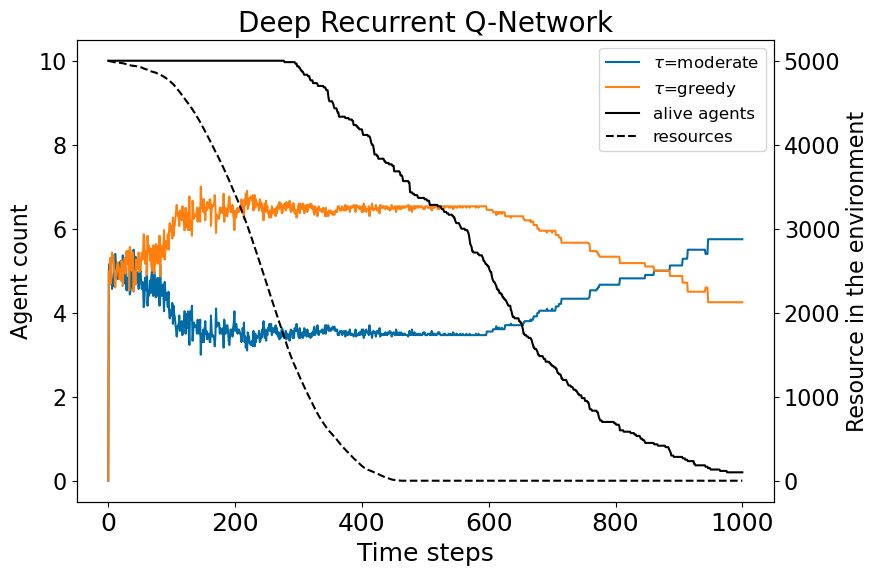

In [233]:
experiment_dict5 = copy.deepcopy(params_dict) # make deep copy of parameter dictionary
experiment_dict5['pop_params']['DRQN'] = 10
experiment_dict5['agent_params']['agent threshold energy'] = [30, 5000]
observations5, stats5, std_dev5 = repeated_simulations(experiment_dict5)
print(stats5)
print(std_dev5)
print(np.sqrt(30 * stats5[-1] * (1 - stats5[-1])))
title5 = 'Deep Recurrent Q-Network'
ths5 = ['moderate', 'greedy']
plot_observations(observations5, title5, ths5)

##### Figure 6 - Online Neuroevolution with choice of thresholds for single agent

[5.27666667e+02 9.66492941e+02 2.57863738e+05 1.66666667e-01]
[2.22848694e+02 4.66745803e+02 7.33142041e+04 3.79049022e-01]
2.041241452319315


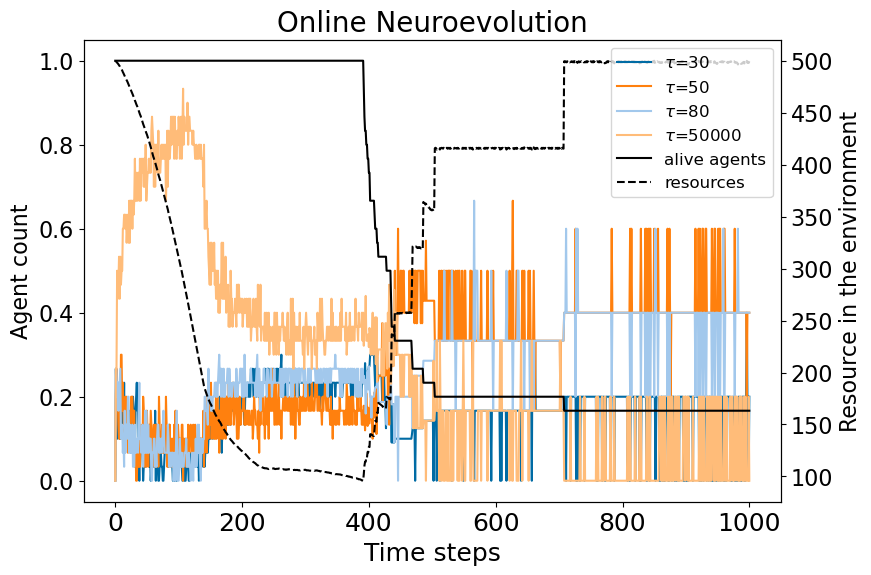

In [234]:
experiment_dict6 = copy.deepcopy(params_dict) # make deep copy of parameter dictionary
experiment_dict6['pop_params']['NE'] = 1
observations6, stats6, std_dev6 = repeated_simulations(experiment_dict6)
print(stats6)
print(std_dev6)
print(np.sqrt(30 * stats6[-1] * (1 - stats6[-1])))
title6 = 'Online Neuroevolution'
ths6 = [30, 50, 80, 50000]
plot_observations(observations6, title6, ths6)

##### Figure 7 - Deep Recurrent Q-Netork with choice of thresholds for single agent

[7.23366667e+02 1.35520366e+03 3.50117487e+05 1.33333333e-01]
[1.51968119e+02 3.17286917e+02 5.21634737e+04 3.45745904e-01]


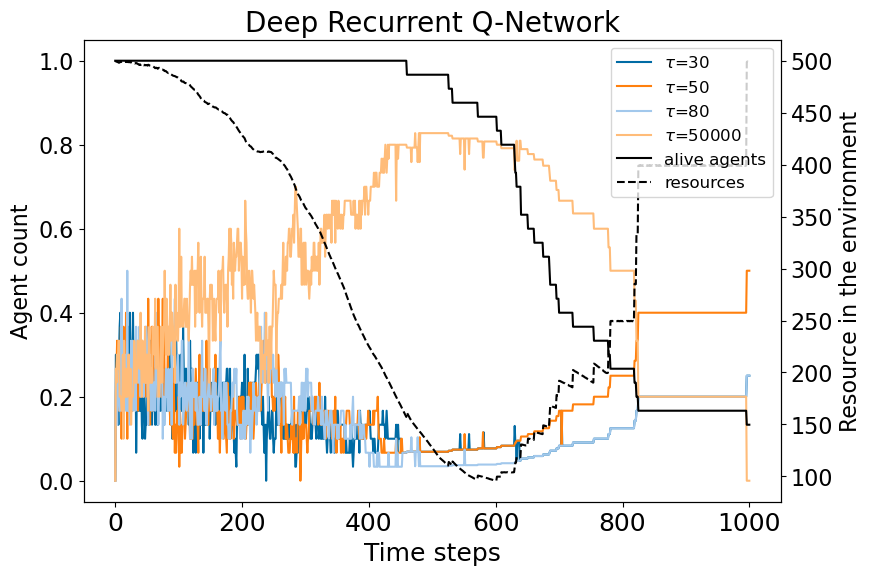

In [235]:
experiment_dict7 = copy.deepcopy(params_dict) # make deep copy of parameter dictionary
experiment_dict7['pop_params']['DRQN'] = 1
# experiment_dict7['expmt_params']['num runs'] = 100
observations7, stats7, std_dev7 = repeated_simulations(experiment_dict7)
print(stats7)
print(std_dev7)
title7 = 'Deep Recurrent Q-Network'
ths7 = [30, 50, 80, 50000]
plot_observations(observations7, title7, ths7)

##### Figure 8 - Online Neuroevolution with LSTM with choice of thresholds for single agent

[8.00633333e+02 1.53648224e+03 3.40674709e+05 6.33333333e-01]
[2.72584626e+02 5.73687604e+02 8.69262745e+04 4.90132518e-01]


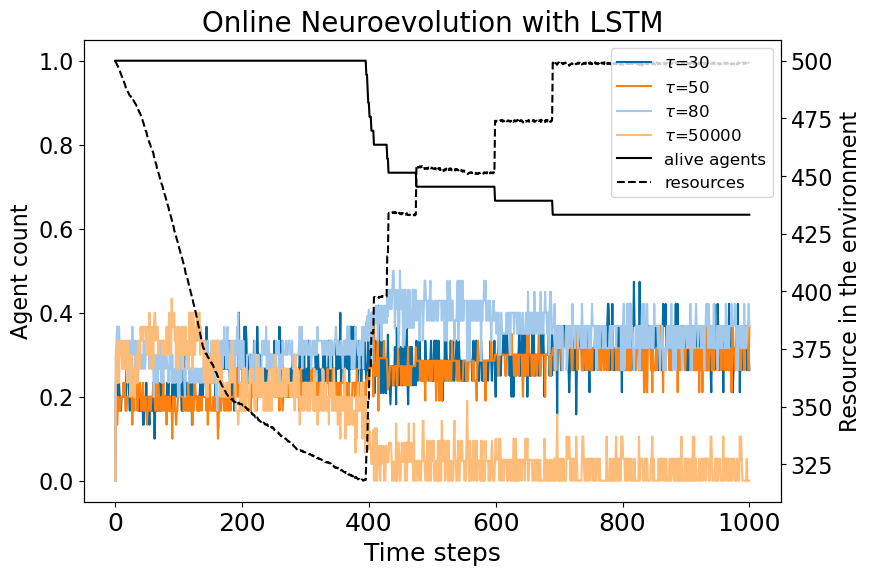

In [237]:
experiment_dict8 = copy.deepcopy(params_dict) # make deep copy of parameter dictionary
experiment_dict8['pop_params']['LSTM-NE'] = 1
# experiment_dict8['expmt_params']['num runs'] = 100
observations8, stats8, std_dev8 = repeated_simulations(experiment_dict8)
print(stats8)
print(std_dev8)
title8 = 'Online Neuroevolution with LSTM'
ths8 = [30, 50, 80, 50000]
plot_observations(observations8, title8, ths8)

##### Figure 9 - Deep Recurrent Q-Network with LSTM with choice of thresholds for single agent

[8.49700000e+02 1.64018200e+03 3.59016713e+05 7.00000000e-01]
[2.33634573e+02 4.94613966e+02 7.15477288e+04 4.66091600e-01]


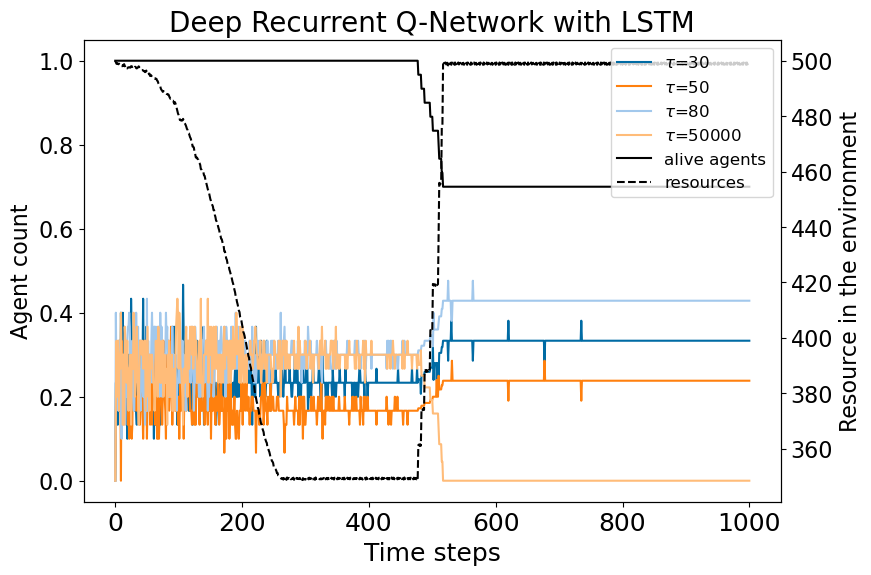

In [238]:
experiment_dict9 = copy.deepcopy(params_dict) # make deep copy of parameter dictionary
experiment_dict9['pop_params']['LSTM-DRQN'] = 1
# experiment_dict9['expmt_params']['num runs'] = 100
observations9, stats9, std_dev9 = repeated_simulations(experiment_dict9)
print(stats9)
print(std_dev9)
title9 = 'Deep Recurrent Q-Network with LSTM'
ths9 = [30, 50, 80, 50000]
plot_observations(observations9, title9, ths9)

##### Figure 10 - Online Neuroevolution with choice of thresholds for 10 agents

[   486.90333333    875.65668511 260213.02248045      0.        ]
[   48.03853685    96.26064752 23774.73431647     0.        ]


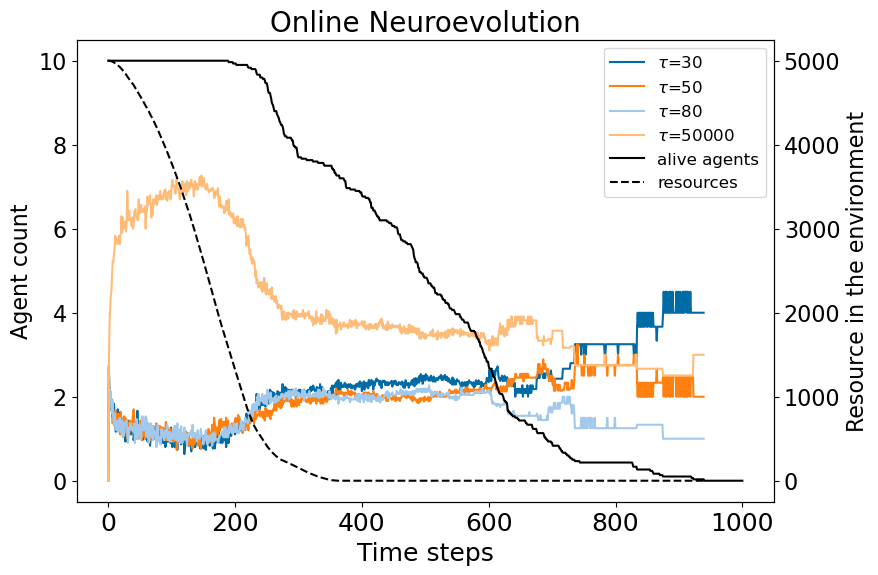

In [239]:
experiment_dict10 = copy.deepcopy(params_dict) # make deep copy of parameter dictionary
experiment_dict10['pop_params']['NE'] = 10
observations10, stats10, std_dev10 = repeated_simulations(experiment_dict10)
print(stats10)
print(std_dev10)
title10 = 'Online Neuroevolution'
ths10 = [30, 50, 80, 50000]
plot_observations(observations10, title10, ths10)

##### Figure 11 - Online Neuroevolution with LSTM with choice of thresholds for 10 agents

[1.08760000e+03 2.16765275e+03 5.30696150e+05 1.36666667e-01]
[8.06006475e+02 1.84018345e+03 3.44840970e+05 3.44897119e-01]


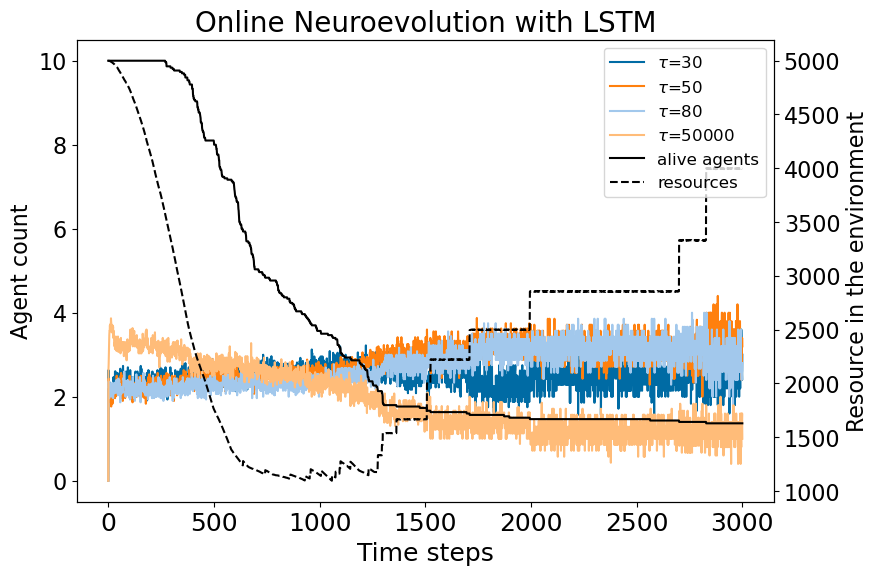

In [240]:
experiment_dict11 = copy.deepcopy(params_dict) # make deep copy of parameter dictionary
experiment_dict11['pop_params']['LSTM-NE'] = 10
experiment_dict11['expmt_params']['num timesteps'] = 3000
observations11, stats11, std_dev11 = repeated_simulations(experiment_dict11)
print(stats11)
print(std_dev11)
title11 = 'Online Neuroevolution with LSTM'
ths11 = [30, 50, 80, 50000]
plot_observations(observations11, title11, ths11)

##### Figure 12 - Comparison of agent types with moderate and greedy baselines for a single agent

[[6.58000000e+02 1.23471537e+03 3.13835787e+05 2.66666667e-01]
 [8.85100000e+02 1.70971975e+03 3.59993692e+05 7.66666667e-01]
 [5.84833333e+02 1.08818200e+03 2.75871884e+05 2.66666667e-01]
 [8.23400000e+02 1.58463439e+03 3.42657715e+05 7.00000000e-01]
 [1.00000000e+03 1.93233333e+03 3.45591556e+05 1.00000000e+00]
 [3.94333333e+02 6.89903658e+02 2.12378053e+05 0.00000000e+00]]


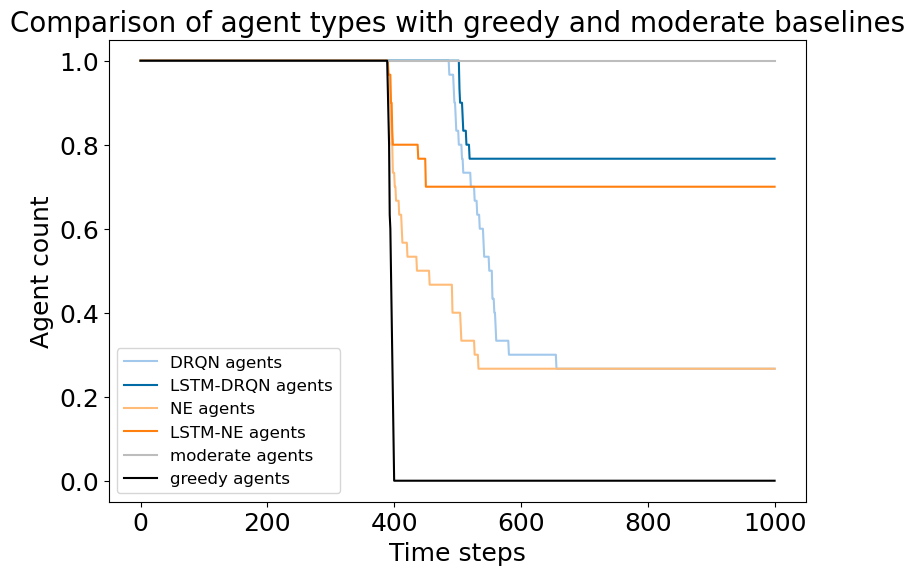

In [188]:
agent_types = ['DRQN', 'LSTM-DRQN', 'NE', 'LSTM-NE', 'moderate', 'greedy'] # specify models for comparison, if none all models are compared
observations12, stats12 = compare_models(params_dict, num_agents=1, keys=agent_types) # run model comparison
title12 = 'Comparison of agent types with greedy and moderate baselines'
print(stats12) # [mean lifetime, mean amount gathered, mean total reward, survival rate]
plot_models_without_resource(params_dict, observations12, agent_types, title12) # Plot model comparison

##### Figure 13 - Comparison of agent types for 10  simultaneous agents

[[7.67776667e+02 1.43643580e+03 3.96095138e+05 0.00000000e+00]
 [1.55514333e+03 3.20046851e+03 7.06929434e+05 3.00000000e-01]
 [5.18023333e+02 9.36480817e+02 2.75838893e+05 0.00000000e+00]
 [1.48602000e+03 3.05311628e+03 7.02735469e+05 3.00000000e-01]]


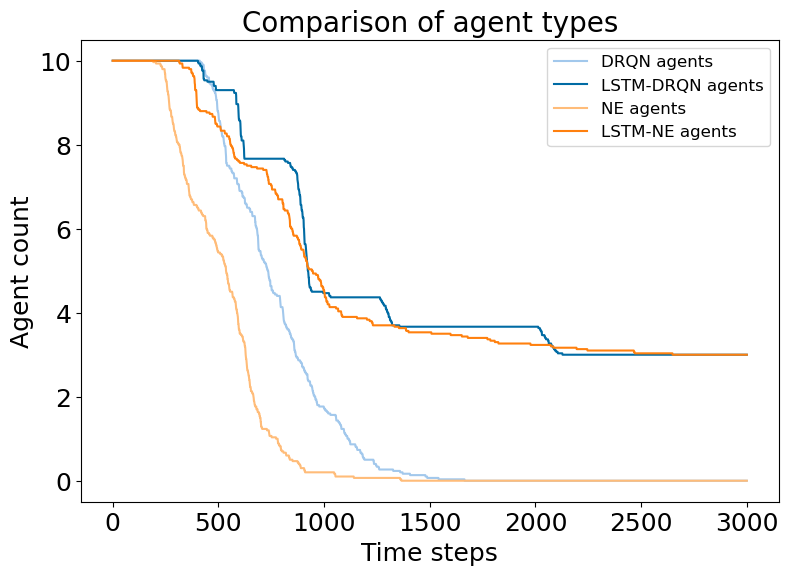

In [189]:
agent_types = ['DRQN', 'LSTM-DRQN', 'NE', 'LSTM-NE'] # specify models for comparison, if none all models are compared
experiment_dict13 = copy.deepcopy(params_dict) # make deep copy of parameter dictionary
experiment_dict13['expmt_params']['num timesteps'] = 3000
experiment_dict13['expmt_params']['num runs'] = 30
observations13, stats13 = compare_models(experiment_dict13, num_agents=10, keys=agent_types) # run model comparison
title13 = 'Comparison of agent types'
print(stats13) # [mean lifetime, mean amount gathered, mean total reward, survival rate]
plot_models_without_resource(experiment_dict13, observations13, agent_types, title13) # Plot model comparison

#### Additional simulation tools

##### Example single simulation

[390.0, 689.9036580538304, 208702.3078346413, 0.0]


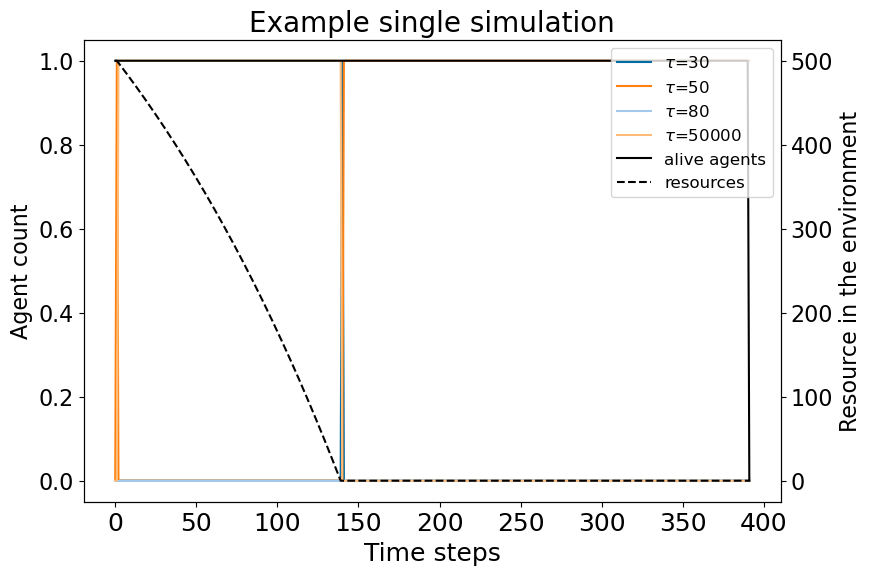

In [35]:
# OBSERVATIONS: n greedy agents, n gathering agents, n alive agents, resources in environment
experiment_dict = copy.deepcopy(params_dict) # make deep copy of parameter dictionary
experiment_dict['pop_params']['NE'] = 1 # modify copy of parameter dictionary to add 1 NE agent
observations, stats = simulate_foraging(experiment_dict) # run single simulation
print(stats) # print simulation statistics: [mean lifetime, mean amount gathered, mean total reward, survival rate]
title = 'Example single simulation' # create title for plot
ths = [30, 50, 80, 50000] # create label for thresholds
plot_observations(observations, title, ths) # create plot

##### Example run-averaged simulation

Conducting simulations: 100%|██████████| 100/100 [01:43<00:00,  1.04s/it]


[6.28630000e+02 1.17887635e+03 2.84959616e+05 3.60000000e-01]


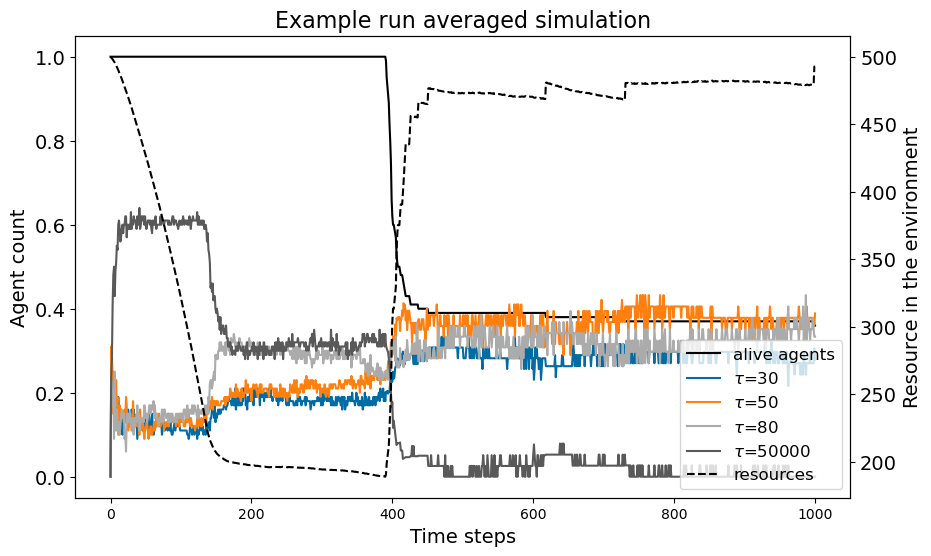

In [68]:
experiment_dict = copy.deepcopy(params_dict) # make deep copy of parameter dictionary
experiment_dict['pop_params']['NE'] = 1
observations, stats, std_dev = repeated_simulations(experiment_dict) # conduct repeated simulations based on number of runs in parameter dictionary
print(stats)
title = 'Example run averaged simulation'
ths = [30, 50, 80, 50000]
plot_observations(observations, title, ths)

##### Parameter Comparison
Can be used to investigate the effect of different parameters such as network population size or to determine best parameters for model tuning

Conducting simulations: 100%|██████████| 100/100 [00:18<00:00,  5.31it/s]


[[1.00000000e+02 3.35450000e+02 4.81394012e+04 1.00000000e+00]
 [1.00000000e+02 3.57900000e+02 4.93747801e+04 1.00000000e+00]
 [1.00000000e+02 3.63550000e+02 4.96494607e+04 1.00000000e+00]
 [1.00000000e+02 3.06500000e+02 4.79145052e+04 1.00000000e+00]
 [1.00000000e+02 2.85650000e+02 4.73931842e+04 1.00000000e+00]]
[6125.755652597186, 5094.977941376549, 5135.725287344592, 4994.78420188181, 4805.56459293297]


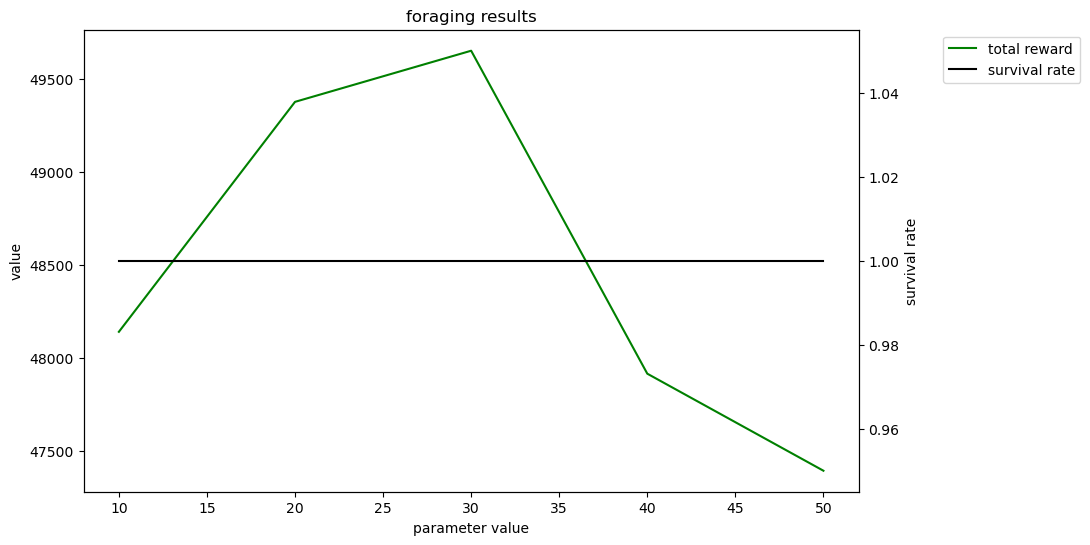

In [37]:
experiment_dict = copy.deepcopy(params_dict) # make deep copy of parameter dictionary
experiment_dict['pop_params']['NE'] = 1
experiment_dict['expmt_params']['num timesteps'] = 100
experiment_dict['expmt_params']['num runs'] = 100
param_group = 'NE_params' # specify parameter group to vary
param = 'pop_size'# specify parameter to vary
param_values = [10, 20, 30, 40, 50] # specify parameter values
experiment_stats, error = conduct_experiment(experiment_dict, param_group, param, param_values) # run parameter comparison
print(experiment_stats) # [mean lifetime, mean amount gathered, mean total reward, survival rate]
print(error)
plot_results(param, param_values, experiment_stats)

##### Model Comparison

Conducting simulations: 100%|██████████| 100/100 [03:23<00:00,  2.03s/it]


[[6.07040000e+02 1.13506027e+03 2.77935745e+05 3.20000000e-01]
 [8.62220000e+02 1.67043761e+03 3.58206531e+05 7.50000000e-01]]


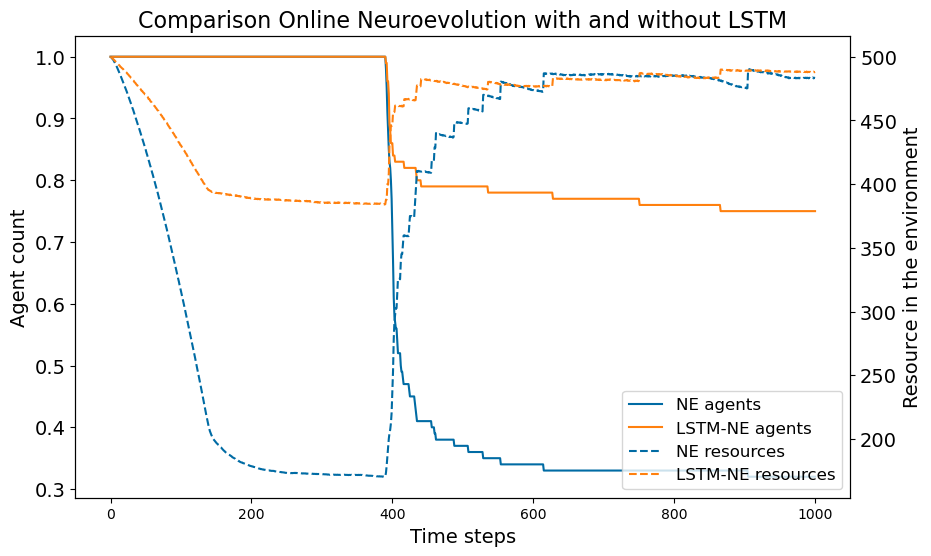

In [70]:
agent_types = ['NE', 'LSTM-NE'] # specify models for comparison, if none all models are compared
observations, stats = compare_models(params_dict, num_agents=1, keys=agent_types) # run model comparison
print(stats) # [mean lifetime, mean amount gathered, mean total reward, survival rate]
title = 'Comparison Online Neuroevolution with and without LSTM'
plot_models(params_dict, observations, agent_types, title) # Plot model comparison

Conducting simulations: 100%|██████████| 100/100 [07:01<00:00,  4.22s/it]


[[7.50180000e+02 1.41996176e+03 3.49590683e+05 3.30000000e-01]
 [8.91520000e+02 1.72780177e+03 3.69817083e+05 7.80000000e-01]]


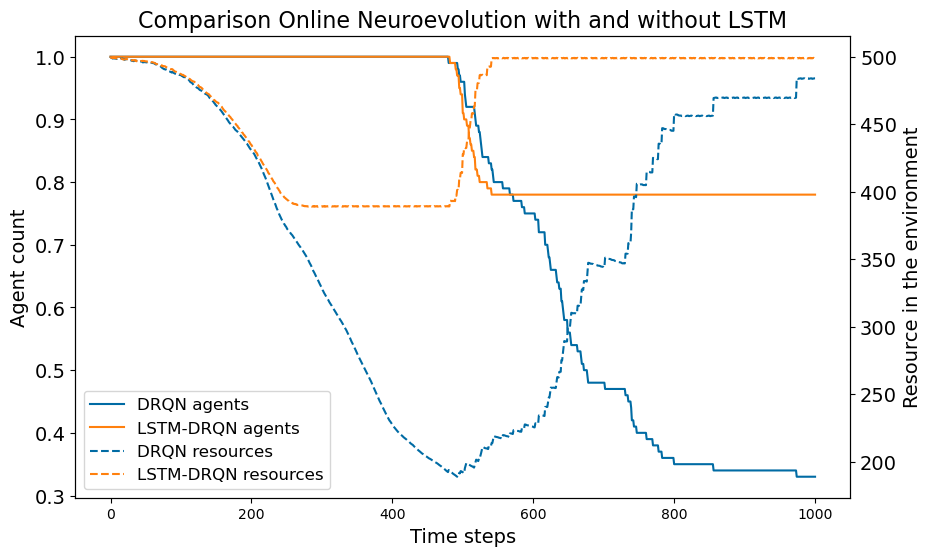

In [72]:
agent_types = ['DRQN', 'LSTM-DRQN'] # specify models for comparison, if none all models are compared
observations, stats = compare_models(params_dict, num_agents=1, keys=agent_types) # run model comparison
print(stats) # [mean lifetime, mean amount gathered, mean total reward, survival rate]
title = 'Comparison Online Neuroevolution with and without LSTM'
plot_models(params_dict, observations, agent_types, title) # Plot model comparison